# Getting Started with Hypothesis Testing

This notebook demonstrates how to get started with frequentist and Bayesian A/B testing as well as multi-armed bandits.

In [1]:
import numpy as np
import pandas as pd
from plotnine import *

import warnings
warnings.filterwarnings('ignore')

In [ ]:
#install michael
# !git clone https://github.com/cstorm125/michael.git
# !cd michael; pip install .

## Frequentist Approach

### Proportions

This example shows how to perform frequentist A/B test based on simulated data with Group `A` (Control) at 10% conversion rate and Group `B` (Test) at 12% conversion rate. 

In [4]:
from michael.utils import gen_proprotions_campaign
from michael.frequentist.proportions import proportion_samples, proportion_test, proportion_ci, proportion_plot

In [5]:
result = gen_proprotions_campaign(p1 = 0.10,
                          p2 = 0.12,
                          timesteps = 60,
                          lmh = [500,1000,1500],
                          scaler=300,
                          seed = 1412) #god-mode 
result.tail()

,timesteps,impression_a,impression_b,conv_a,conv_b,cumu_impression_a,cumu_impression_b,cumu_conv_a,cumu_conv_b,cumu_rate_a,cumu_rate_b
55,55,1101,1175,109,143,55364,55210,5478,6545,0.098945,0.118547
56,56,789,867,76,108,56153,56077,5554,6653,0.098908,0.118640
57,57,929,925,92,114,57082,57002,5646,6767,0.098910,0.118715
58,58,973,969,96,113,58055,57971,5742,6880,0.098906,0.118680
59,59,1449,973,148,113,59504,58944,5890,6993,0.098985,0.118638


First, we need to determine our minimum detectable effect (what is the minimum difference you would consider `B` as the better variation) to get the required sample size with `proportion_samples` and avoid the problem of if-you-have-enough-samples-everything-is-significant. We can see that we could have stopped our fake experiment much sooner than we did!

In [6]:
mde = 0.01
required_samples = proportion_samples(mde = mde, #we will say that B is better if it is at least 1% better than A
                                      p  = 0.1, #expected probability under null hypothesis i.e. everything is same as A at 10%,
                                      alpha = 0.05 #acceptable alpha that we will reject the null hypothesis
                                     )
print(f'We need at least {required_samples} impressions in each group to detect the minimum difference of {int(100*mde)}% in conversion rate.')

We need at least 4869.978217371743 impressions in each group to detect the minimum difference of 1% in conversion rate.


In [7]:
result_trunc = result[result.cumu_impression_a<required_samples]
result_trunc.tail() #we see that we should have stopped at timestep much earlier than we did

,timesteps,impression_a,impression_b,conv_a,conv_b,cumu_impression_a,cumu_impression_b,cumu_conv_a,cumu_conv_b,cumu_rate_a,cumu_rate_b
0,0,1254,1007,126,120,1254,1007,126,120,0.100478,0.119166
1,1,1147,549,116,68,2401,1556,242,188,0.100791,0.120823
2,2,678,955,67,112,3079,2511,309,300,0.100357,0.119474
3,3,968,764,94,93,4047,3275,403,393,0.099580,0.120000


We can then run the `proportion_plot` function to get test results with plot.

Z-value: -2.7910277348496275; p-value: 0.0026270484959149965


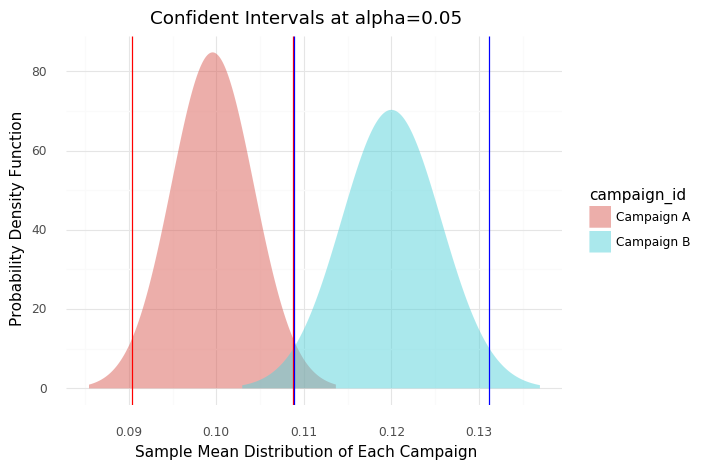

In [8]:
c1,c2 = result_trunc.loc[result_trunc.shape[0]-1,'cumu_conv_a'],result_trunc.loc[result_trunc.shape[0]-1,'cumu_conv_b']
n1,n2 = result_trunc.loc[result_trunc.shape[0]-1,'cumu_impression_a'],result_trunc.loc[result_trunc.shape[0]-1,'cumu_impression_b']

proportion_plot(c1,c2,n1,n2, alpha=0.05, mode='one_sided')

We can also run the test and get confidence intervals separating using `proportion_test` and `proportion_ci`.

In [9]:
z,p_value = proportion_test(c1,c2,n1,n2,mode='one_sided')
print(f'Z-score: {z} at p-value {p_value}')

Z-score: -2.7910277348496275 at p-value 0.0026270484959149965


In [10]:
l1,u1 = proportion_ci(c1,n1,alpha=0.05)
l1,u1

(0.09035443408810212, 0.10880543742165819)

In [11]:
l2,u2 = proportion_ci(c2,n2,alpha=0.05)
l2,u2

(0.10887053218331917, 0.13112946781668083)

**Coding Assingment** Take turn with your buddy to play the **Frequentist A/B Test Game**. One player is Generator and the other is the Tester. The game is as follows:
1. Generator chooses conversion rates `p1` and `p2` that they like, as well as impression variables `lmh` and Gaussian noise `scaler`. 
2. Generator runs `gen_proprotions_campaign` for 1000 days to get average impressions of A and B. Generator then tells Testor the average impressions per day.
3. Tester designs the frequentist A/B test to determine which campaign is better A or B. Things to consider include:
    * What is the mininum detectable effect?
    * How many samples are enough samples? 
    * How many days should the experiment run?
    * What should be the p-value threshold?
4. After the design is finished, the Tester tells Generator how many days they want to run the experiment.
5. Generator runs `gen_proprotions_campaign` again with `timesteps` parameter equals to the number of days Testor told them.
6. Tester performs frequentist A/B test to determine if which is better A or B, and explains their reasoning.

In [ ]:
'''
Fill in the codes
'''

## Bayesian Approach

### Proportions

This example shows how to perform Bayesian A/B test based on simulated data with Group `A` (Control) at 10% conversion rate and Group `B` (Test) at 12% conversion rate. 

In [10]:
from michael.utils import gen_proprotions_campaign
from michael.bayesian.proportions import sample_proportion, proportion_test_b, proportion_plot_b, proportion_ratio, proportion_diff, value_remaining

In [11]:
result = gen_proprotions_campaign(p1 = 0.10,
                          p2 = 0.12,
                          timesteps = 24,
                          lmh = [50,100,150],
                          scaler=300,
                          seed = 1412) #god-mode 
result.tail()

,timesteps,impression_a,impression_b,conv_a,conv_b,cumu_impression_a,cumu_impression_b,cumu_conv_a,cumu_conv_b,cumu_rate_a,cumu_rate_b
19,19,80,129,8,16,2044,1866,192,213,0.093933,0.114148
20,20,100,101,9,12,2144,1967,201,225,0.093750,0.114387
21,21,135,77,13,8,2279,2044,214,233,0.093901,0.113992
22,22,112,93,11,11,2391,2137,225,244,0.094103,0.114179
23,23,97,72,9,8,2488,2209,234,252,0.094051,0.114079


The assumption we need to establish for Bayesian A/B testing is the priors; you can set a different prior for each group `A` and `B` or use the same one. The stopping criteria for Bayesian A/B testing depends on this prior and a concept called **value remaining**. Usually we stop the experiment once the value remaining falls below a certain threshold, say 0.01.

In [12]:
a,b = 1,9
sim_size = 100000
q = 95
threshold = 0.01

result['value_remaining'] = result.apply(lambda row: value_remaining([row['cumu_conv_a'],row['cumu_conv_b']],
                                                                     [row['cumu_impression_a'],row['cumu_impression_b']],
                                                                     [a,a],[b,b],q,sim_size),1)
result_trunc = result[result.value_remaining>threshold]
result_trunc.tail()

,timesteps,impression_a,impression_b,conv_a,conv_b,cumu_impression_a,cumu_impression_b,cumu_conv_a,cumu_conv_b,cumu_rate_a,cumu_rate_b,value_remaining
8,8,94,90,9,10,955,872,91,98,0.095288,0.112385,0.064879
9,9,102,94,9,10,1057,966,100,108,0.094607,0.111801,0.050812
10,10,86,133,8,16,1143,1099,108,124,0.094488,0.112830,0.026381
11,11,94,56,9,6,1237,1155,117,130,0.094584,0.112554,0.024347
12,12,86,72,8,8,1323,1227,125,138,0.094482,0.112469,0.020314


Bayesian A/B test can directly tell you both **the probability that A will outperform B** and the **magnitude of ratio or difference between the group**. Use `proportion_plot_b`.

Probability that A is better than B: 0.06768
Average ratio of A and B: 0.8462521754997488
Credible interval: [0.66807453 1.05517617]


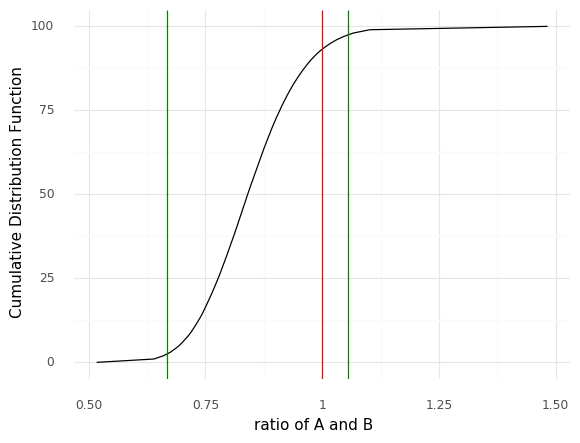

In [13]:
c1,c2 = result_trunc.loc[result_trunc.shape[0]-1,'cumu_conv_a'],result_trunc.loc[result_trunc.shape[0]-1,'cumu_conv_b']
n1,n2 = result_trunc.loc[result_trunc.shape[0]-1,'cumu_impression_a'],result_trunc.loc[result_trunc.shape[0]-1,'cumu_impression_b']

proportion_plot_b(c1,c2,n1,n2,0.05,'ratio',a,a,b,b,sim_size)

We can also run just the test separately as well as sampling from the posteriors to get credible intervals with `proportion_test_b` and `sample_proprotion`.

In [14]:
print(f'Probability that A is better than B: {proportion_test_b(c1,c2,n1,n2,a,a,b,b,sim_size)}')

Probability that A is better than B: 0.06639


In [15]:
ci_a = np.percentile(sample_proportion(c1,n1,a,b,sim_size), [2.5,97.5])
ci_b = np.percentile(sample_proportion(c2,n2,a,b,sim_size), [2.5,97.5])
print(f'Credible interval for A: {ci_a}')
print(f'Credible interval for B: {ci_b}')

Credible interval for A: [0.07930378 0.110806  ]
Credible interval for B: [0.09541691 0.13058075]


**Coding Assingment** Take turn with your buddy to play the **Bayesian A/B Test Game**. One player is Generator and the other is the Tester. The game is as follows:
1. Generator chooses conversion rates `p1` and `p2` that they like, as well as impression variables `lmh` and Gaussian noise `scaler`. 
2. Generator runs `gen_proprotions_campaign` for 1000 days to get average conversion rates of A and B then tell the Tester.
3. Tester designs the Bayesian A/B test to determine which campaign is better A or B. Things to consider include:
    * What is a good prior for A and B?
    * What is a good simulation size for drawing samples from the posterior?
    * When should we stop the test?
    * What is a good value remaning threshold?
4. After the design is finished, the Tester tells Generator the value remaining when they should stop the experiment.
5. Generator runs `gen_proprotions_campaign` with a relatively large number of `timesteps`, say 1,000. Generator truncates the result dataframe at the point where value remaining is lower than the value remaning threshold given by the Tester.
6. Tester performs Bayesian A/B test to determine if which is better A or B, and explains their reasoning.

In [ ]:
'''
Fill in the codes
'''

## Multi-armed Bandits

### Proportions

We treat the problem of selecting the best variation as pulling the arm of the best slot machines. Here we use the simulation environment `MusketeerEnv` which returns the status of each arm in a form of the tuple `(impressions,clicks)`. The environment also keeps track of value remaining for stopping criteria.

In [15]:
from michael.mab.env import MusketeerEnv
from michael.mab.agent import BanditAgent
env = MusketeerEnv(true_ps = [0.12,0.13,0.14], avg_impressions=400)

#starting scores for each arm
env.reset()

[(0, 0), (0, 0), (0, 0)]

The agent has many policies it can run. We suggest using `thompson_stochastic` for optimal results.

In [16]:
#initiate agent with priors
a = BanditAgent(a=1,b=9)

#warm up the environment with 20 episodes of equal-weight actions
for i in range(20):
    p = a.equal_weights(env.get_state())
    env.step(p)
    t=i

#how agent choose arms with given priors
a.equal_weights(env.get_state()), a.randomize(env.get_state()), a.eps_greedy(env.get_state(),t),\
a.softmax(env.get_state(),t), a.thompson_stochastic(env.get_state()), \
a.ucb(env.get_state(),t), a.thompson_deterministic(env.get_state())

(array([0.33333333, 0.33333333, 0.33333333]),
 array([0.35248605, 0.3183263 , 0.32918765]),
 array([0.08261686, 0.08261686, 0.83476628]),
 array([0.33236602, 0.3338164 , 0.33381757]),
 array([0.001, 0.222, 0.777]),
 array([0., 0., 1.]),
 array([0., 1., 0.]))

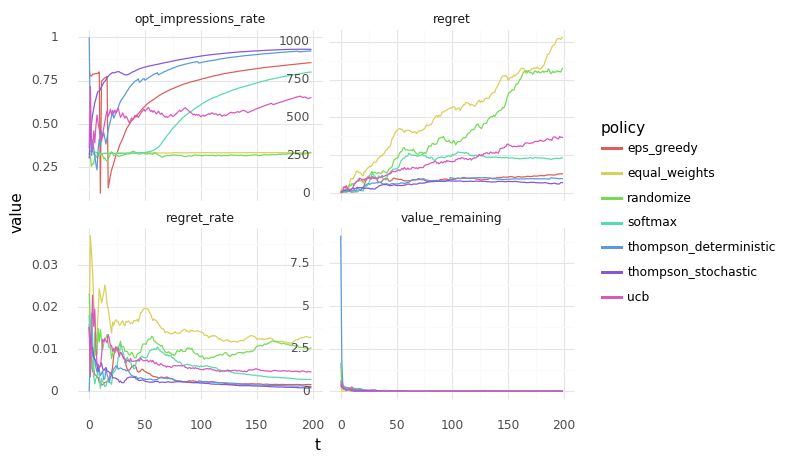

<ggplot: (302679935)>

In [18]:
#seven environments to run with each policy
envs = [MusketeerEnv(true_ps = [0.12,0.13,0.14], avg_impressions=400) for i in range(7)]
a = BanditAgent(a=1,b=9)

#run all environments for 200 timesteps
for t in range(200):
    states = [env.get_state() for env in envs]
    actions = [a.equal_weights(states[0]), a.randomize(states[1]),
               a.eps_greedy(states[2],t), a.softmax(states[3],t),
               a.thompson_stochastic(states[4]),
               a.ucb(states[5],t), a.thompson_deterministic(states[6])]
    for i in range(7): envs[i].step(actions[i])
        
#record results
dfs = [env.show_df() for env in envs]
policies = ['equal_weights','randomize','eps_greedy','softmax','thompson_stochastic',
            'ucb','thompson_deterministic']
for i in range(7): dfs[i]['policy'] = policies[i]
df = pd.concat(dfs)[['policy','t','opt_impressions_rate','regret_rate','regret','value_remaining']]
df_m = df.melt(id_vars=['policy','t'])

#plot
g = (ggplot(df_m, aes(x='t',y='value',color='policy',group='policy')) +
    geom_line() + theme_minimal() + facet_wrap('~variable',scales='free_y'))
g